# Deep Q-Learning on Lunar Lander 🚀

This project applies **Deep Q-Networks (DQN)** to the classic control problem **Lunar Lander** from OpenAI Gym.
I implemented this as part of my machine learning coursework, but modified and annotated the code to better understand how agents learn through reinforcement.

The main goal was to train an agent to land safely by approximating the Q-value function using a neural network built in PyTorch.


# Deep Reinforcement Learning

In this part of the assignment you will work on a more challenging control task in the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). The state space is continuous and we will employ Deep Q-Learning (DQN) using a deep neural network to handle generalizing between states.

**Learning objectives.** You will:
1. Implement the Deep Q-learning (DQN) algorithm with epsilon greedy action selection
2. Apply DQN to train an agent on a challenging control task with a large (continuous) state space
3. Evaluate the learning curve of average episodic return over training

While it is possible to complete this assignment using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

If you were able to run `pip install "gymnasium[all]"` in Part 1 then you may not need to install any additional dependencies to work with the Lunar Lander environment. However, if you were only able to install the base `gymnasium` then you may need to complete the additional installations of `swig` and `box2d` below. The first two commands use `pip` for the package manager, the third uses `conda` if you are using the Anaconda package manager.

In [1]:
pip install swig

In [2]:
pip install gymnasium

In [3]:
pip install box2d-py

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2379367 sha256=bc916dc59483db7ca32618dd82f40645a4215061db9d33ba24cfe6253ac32f6a
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py


In [ ]:
#conda install -c conda-forge swig box2d-py

You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/), and then execute random actions in the environment.

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions. **Be aware that the visualization can be unstable on some platforms -- in particular, if you cannot generate the visualization or if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment** (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [4]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
for _ in range(200):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Task 1

As we will be implementing DQN, your first task is to define a deep neural network architecture to use to estimate the Q function during training. You should familiarize yourself with the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) documentation to understand the state/observation space, action space, and reward function.

In [5]:
import torch
import torch.nn as nn

class NeuralNet(torch.nn.Module):
    """
    Implements a neural network representation of
    the q-function for use in DQN.
    """
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        # todo: complete constructor/initialization
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()


    def forward(self, x):
        """
        Input should represent state/observation space encoding
        Output should be a q-function estimate for each possible
        discrete action.
        """
        # todo: complete forward method
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        #pass # remove pass when implementing

## Task 2

Your next task is to define the `LunarLanderAgent` which should also implement the deep Q-learning (DQN) algorithm. The structure of the class is left up to you: While you are welcome to adopt a similar structure of `__init__`, `action_select`, and `update` as in Part 1, you are also free to change the structure as you see fit.

The implementation will be more challenging than in the Part 1 tabular case. You may wish to review 11/25's lecture in particular for a discussion of the implementation. A few tips and reminders:
1. You should use a main Q-network, the weights of which you will regular update, and a frozen target Q-network used to predict the future predictive target, the weights of which you will periodically copy from the main Q-network. You should copy these weights only everal several thousand steps in the environment for stability. Both should share the same architecture you defined above and should be saved as instance variables of your agent, along with a PyTorch loss MSE loss function and optimizer.
2. You should use an experience replay buffer and employ batched updates to the weights of your Q-network. The easiest data structure to use for the experience replay buffer is probably the [Python collections deque](https://docs.python.org/3/library/collections.html#collections.deque). You probably want an experience replay buffer that is at least as large as 100,000 experiences, if not more.
3. You will likely need a lower learning rate such as `0.001` or `0.0005`. Also, you will want a good amount of exploration early on. If using `epsilon` decay, you should decay only very slowly, as you should expect to need thousands of episodes to learn a good policy.
4. While you are not required to use GPU training for Q-network operations, it will substantially accelerate training, and you are encouraged to do so. Make sure not to store all of the experiences in your entire experience replay buffer on the GPU. Instead, store those on CPU memory and only move batches on GPU before training. Otherwise you are likely to run out of memory during training.

In [6]:
class LunarLanderAgent:
    """
    Implements a deep Q-learning agent for the Lunar Lander environment.
    """
    def __init__(self, state_dim, n_actions, gamma=0.99, batch_size=64, # add state_dim and n_actions, and set default values for other parameters
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 target_update_freq=1000, buffer_size=100000, lr=0.001):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.main_q = NeuralNet(input_dim=state_dim, output_dim=n_actions).to(self.device) # pass input_dim and output_dim
        self.target_q = NeuralNet(input_dim=state_dim, output_dim=n_actions).to(self.device) # pass input_dim and output_dim
        self.target_q.load_state_dict(self.main_q.state_dict())

        self.target_q.eval()
        self.optimizer = optim.Adam(self.main_q.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.main_q(state_tensor)
            return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return  # not enough experiences in buffer to update
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states).to(self.device)

        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)

        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        q_values = self.main_q(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_q(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_q.load_state_dict(self.main_q.state_dict())

## Task 3

Train your DQN agent on the Lunar Lander environment. You should be able to learn a policy that achieves an average/expected episode return (cumulative reward) of approximately 200 or more -- **we will consider the training a success if the average/expected episode return converges to greater than 150**. To accomplish this you may need to experiment with several of the key hyperparameters for the learning agent. Note that the learning will likely be much more challenging and variable than in the Part 1 warmup task.

While you are not required, you are encouraged to print periodic evaluation information during training (for example, every 100 or so episodes you may wish to printout the average return of the last 100 episodes) in order to track progress.

Training will take quite some time on this environment: You should expect to need between **1 and 10 thousand episodes** of experience (You should use a small number between 100 and 1 thousand while prototyping your implementation, then several thousand for your final training). Even with GPU acceleration you should expect this to take **several minutes or as much as an hour** (for your final run over several thousand episodes). Partially for this reason, you are strongly encourage to **save your Q-network model parameters** after a substantial and long training run, to ensure you do not lose them. See the [PyTorch documentation on loading and saving model parameters](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

It is relatively common/likely on this lunar lander environment to get stuck in a local optimum where the agent learns to "hover" but not land. Landing correctly is difficult and crashing incurs a large negative reward, so sometimes the agent gets "stuck" in a policy of hovering in place without attempt to land. This results in an average return of around 0. If your agent is getting stuck like this, one recommendation is to modify the reward function by adding a per-timestep reward penalty during learning. You can do this very simply in the training loop by just reducing the reward as in `r = r - timestep_penalty` before passing the experience to your agent. A value for `timestep_penalty` between 0.1 and 0.5 may help to incentivize the agent not to "hover" but to actually attempt and learn how to land.

In [7]:
import gymnasium as gym
from torch import optim
import random
from collections import deque

n_episodes = 1000

env = gym.make("LunarLander-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
agent = LunarLanderAgent(state_dim=state_dim, n_actions=n_actions)

rewards_list = []

for episode in range(n_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.store_transition(state, action, reward, next_state, done)
        agent.update()

        state = next_state
        total_reward += reward

    rewards_list.append(total_reward)

    if (episode + 1) % 20 == 0:
        avg_reward = sum(rewards_list[-20:]) / 20
        print(f"Episodes {episode - 20 + 2} to {episode + 1}: Average Total Reward: {avg_reward:.2f}")

env.close()

Episodes 1 to 20: Average Total Reward: -425.64
Episodes 21 to 40: Average Total Reward: -340.76
Episodes 41 to 60: Average Total Reward: -95.57
Episodes 61 to 80: Average Total Reward: -63.01
Episodes 81 to 100: Average Total Reward: 57.61
Episodes 101 to 120: Average Total Reward: -32.04
Episodes 121 to 140: Average Total Reward: -116.39
Episodes 141 to 160: Average Total Reward: -43.10
Episodes 161 to 180: Average Total Reward: -67.84
Episodes 181 to 200: Average Total Reward: -12.30
Episodes 201 to 220: Average Total Reward: 103.57
Episodes 221 to 240: Average Total Reward: 38.09
Episodes 241 to 260: Average Total Reward: 140.01
Episodes 261 to 280: Average Total Reward: 202.73
Episodes 281 to 300: Average Total Reward: 138.55
Episodes 301 to 320: Average Total Reward: 189.43
Episodes 321 to 340: Average Total Reward: 212.24
Episodes 341 to 360: Average Total Reward: 194.22
Episodes 361 to 380: Average Total Reward: 136.99
Episodes 381 to 400: Average Total Reward: 193.66
Episodes 

## Task 4

After training, you can use the `visualize_learning_curves` function below to create two plots: One of the moving average episode return over the course of training and another of the moving average episode length over the course of training. A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately 150 or above. The learning may be more variable than in Part 1, so you may wish to increase the `smoothing` parameter to `50` or even `100` to make it easier to visualize the average trend.

In [8]:
# Run, but you do not need to modify this code

import numpy as np
from matplotlib import pyplot as plt

def visualize_learning_curves(env, smoothing=10):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(env.return_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(env.length_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

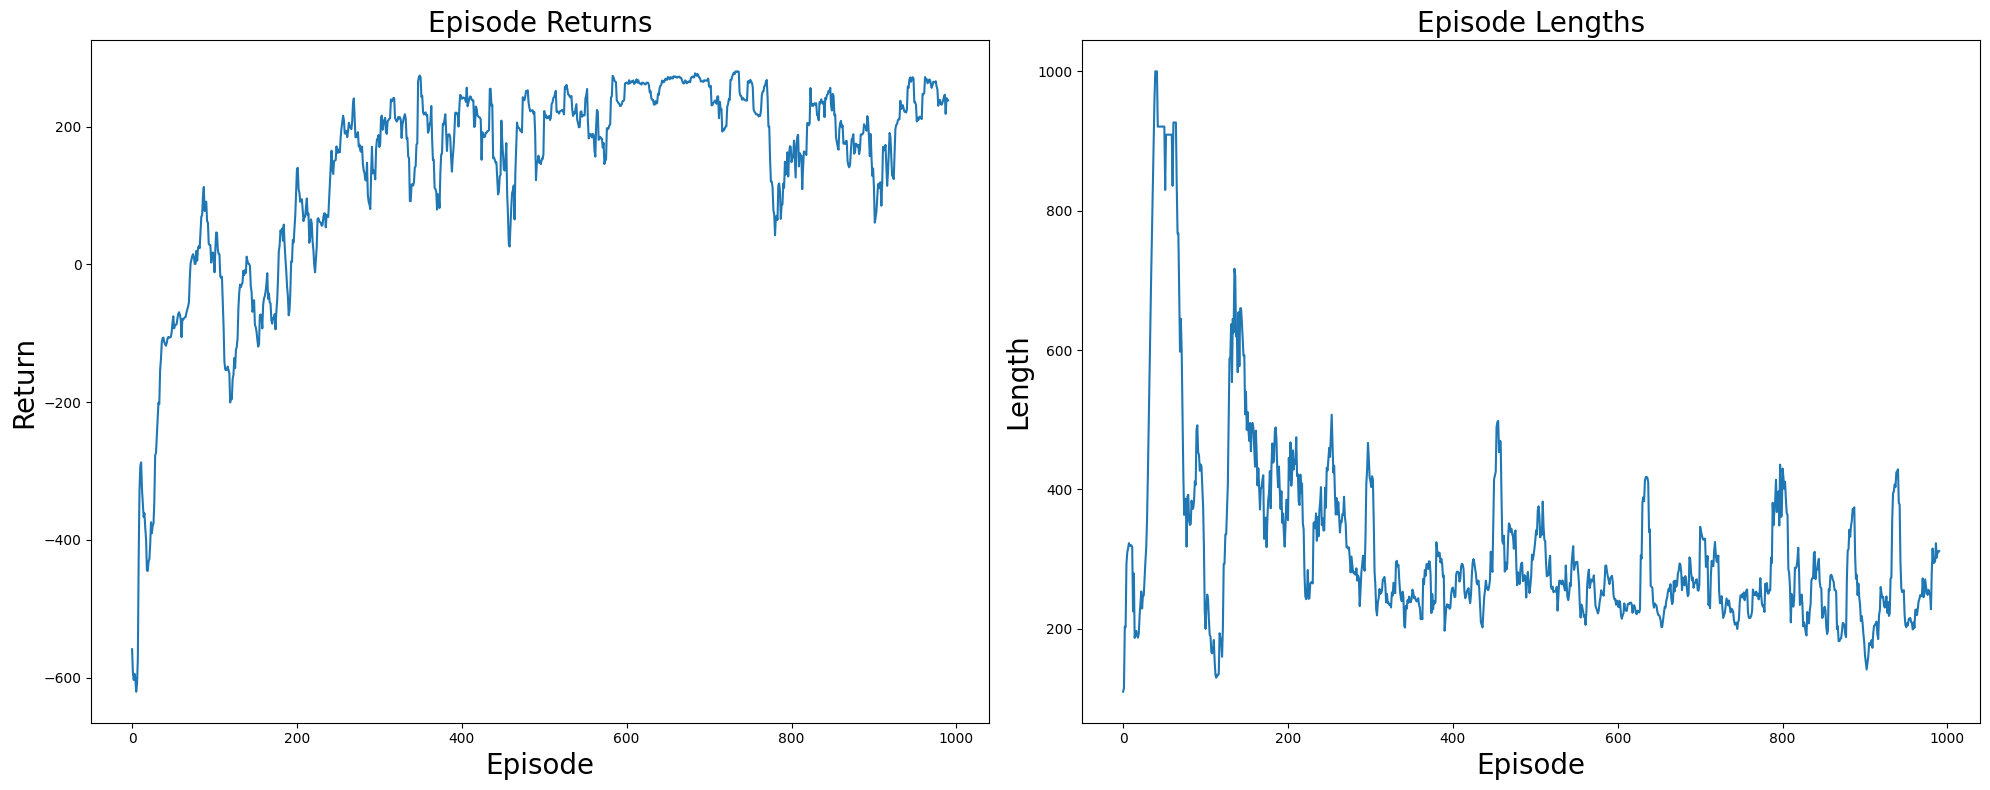

In [9]:
# todo: visualize learning curves
visualize_learning_curves(env, smoothing=10)

## Optional

The above evaluation of the learning curve was purely quantiative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below. To do so, render the environment in `"human"` mode as shown below. This should render the visualization of the environment. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

Again, be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [20]:
import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v3", render_mode="human")
agent.epsilon = 0  # Fully exploit learned policy
agent.main_q.eval()

for episode in range(5):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    print(f"Episode {episode+1} reward: {total_reward}")

env.close()



Episode 1 reward: 283.66721341624316
Episode 2 reward: 197.49912860312202
Episode 3 reward: 282.89082784132347
Episode 4 reward: 146.79472611895045
Episode 5 reward: 223.6540704127113


## Results

After sufficient training episodes, the agent was able to consistently land the Lunar Module without crashing.

Key outcomes:
- Agent learned to balance fuel usage with soft landings.
- Neural network approximated long-term reward values using Bellman equations.
- Epsilon-greedy exploration helped balance learning with exploitation.

This project helped me develop a practical understanding of **value-based reinforcement learning**, experience building models in **PyTorch**, and familiarity with the **OpenAI Gym** interface.
